# WATER QUALITY PREDICTION

# Importing libraries

In [2]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

from pylab import *
from pyspark.sql.functions import udf, concat, col, lit
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(sc)

# Reading the dataset and describing

In [4]:
df = spark.read.format("csv").option("header", "true").load('/home/hdoop/sparkpro/waterquality.csv')

In [5]:
df.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|         735|3.4|                  2|             3|            73|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|  6|  8|         270|3.1|                  2|            72|           182|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|         355|4.2|                  9|            59|           133|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|         371|5.6|               3.55|            90|           283|
|        2183|GODAVARI RIVER AT...|MAHARASHTRA|25.7|5.7|7.9|         294|3.2|               2.69|       

In [6]:
df.dtypes

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'string'),
 ('DO', 'string'),
 ('pH', 'string'),
 ('CONDUCTIVITY', 'string'),
 ('BOD', 'string'),
 ('NITRATE_N_NITRITE_N', 'string'),
 ('FECAL_COLIFORM', 'string'),
 ('TOTAL_COLIFORM', 'string')]

In [7]:
df.head()

Row(STATION CODE='1312', LOCATIONS='GODAVARI AT JAYAKWADI DAM, AURNAGABAD,MAHARASHTRA', STATE='MAHARASHTRA', TEMP='29.2', DO='6.4', pH='8.1', CONDUCTIVITY='735', BOD='3.4', NITRATE_N_NITRITE_N='2', FECAL_COLIFORM='3', TOTAL_COLIFORM='73')

In [10]:
df.describe()

DataFrame[summary: string, STATION CODE: string, LOCATIONS: string, STATE: string, TEMP: string, DO: string, pH: string, CONDUCTIVITY: string, BOD: string, NITRATE_N_NITRITE_N: string, FECAL_COLIFORM: string, TOTAL_COLIFORM: string]

# Data cleaning

In [11]:
from pyspark.sql.types import FloatType

As we can see above that all the columns have string data types, but for the calculation of water quality index we need to convert them in float data type. So we will convert the required columns to float data type.

In [12]:
df = df.withColumn("TEMP",df["TEMP"].cast(FloatType()))
df = df.withColumn("pH",df["pH"].cast(FloatType()))
df = df.withColumn("DO",df["DO"].cast(FloatType()))
df = df.withColumn("CONDUCTIVITY",df["CONDUCTIVITY"].cast(FloatType()))
df = df.withColumn("BOD",df["BOD"].cast(FloatType()))
df = df.withColumn("NITRATE_N_NITRITE_N",df["NITRATE_N_NITRITE_N"].cast(FloatType()))
df = df.withColumn("FECAL_COLIFORM",df["FECAL_COLIFORM"].cast(FloatType()))

In [13]:
df.dtypes

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float'),
 ('TOTAL_COLIFORM', 'string')]

Now the column TOTAL_COLIFORM is not required so we will drop this column.

In [14]:
df=df.drop('TOTAL_COLIFORM')

Now we have to check all the rown for nulla values and remove all the rows which contain any null value in it.

 So for applying a SQL query we first have to register it has a virtual temporary table and then we will issue SQL query.

We are doing this because it is important to perform data cleaning as it will make our model to work with better prediction and accuracy.

In [15]:
df.createOrReplaceTempView("df_sql")

In [16]:
df_clean = spark.sql('''Select * from df_sql where TEMP is not null and DO is not null 
                        and pH is not null and BOD is not null and CONDUCTIVITY is not null
                        and NITRATE_N_NITRITE_N is not null and FECAL_COLIFORM is not null''')

In [17]:
df.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0|3.4|                2.0|           3.0|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0|3.1|                2.0|          72.0|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0|4.2|                9.0|          59.0|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|       371.0|5.6|               3.55|          90.0|
|        2183|GODAVARI RIVER AT...|MAHARASHTRA|25.7|5.7|7.9|       294.0|3.2|               2.69|          45.0|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------

# EDA - Exploratory data analysis

In [18]:
df_clean.createOrReplaceTempView("df_sql")

In [20]:
do = spark.sql("Select DO from df_sql")
do = do.rdd.map(lambda row : row.DO).collect()
ph = spark.sql("Select pH from df_sql")
ph = ph.rdd.map(lambda row : row.pH).collect()
bod = spark.sql("Select BOD from df_sql")
bod = bod.rdd.map(lambda row : row.BOD).collect()
nn = spark.sql("Select NITRATE_N_NITRITE_N from df_sql")
nn = nn.rdd.map(lambda row : row.NITRATE_N_NITRITE_N).collect()

Data visualization

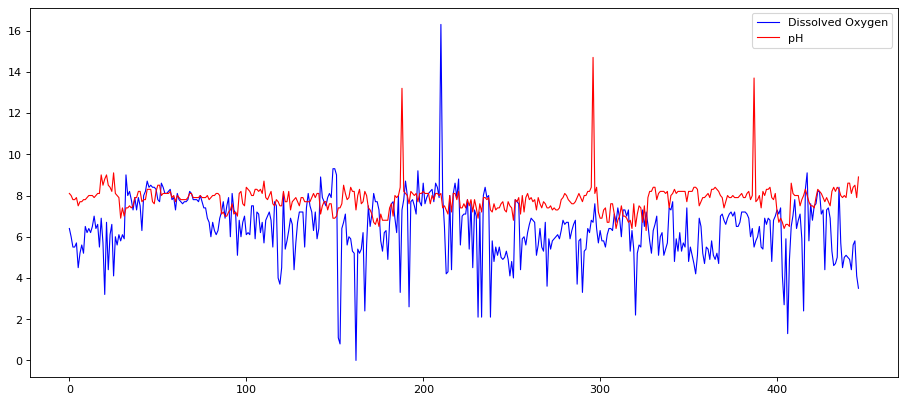

In [21]:
fig,ax = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
size=len(do)
ax.plot(range(0,size), do, color='blue', animated=True, linewidth=1, label='Dissolved Oxygen')
ax.plot(range(0,size), ph, color='red', animated=True, linewidth=1, label='pH')
legend=ax.legend()

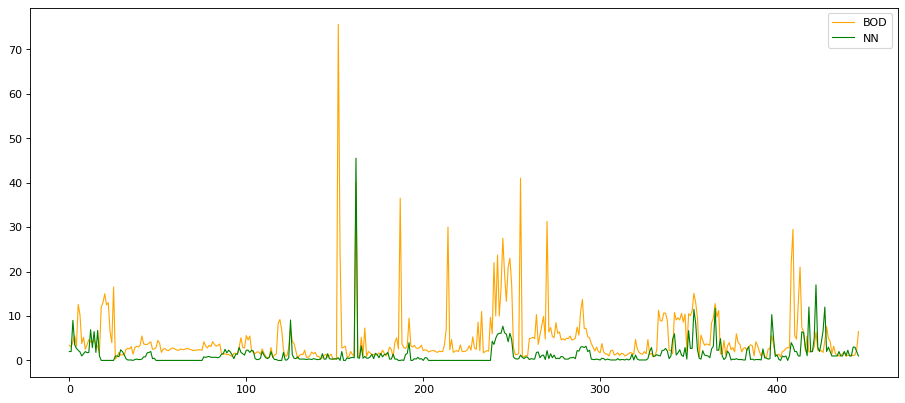

In [22]:
fig,ax2 = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax2.plot(range(0,size), bod, color='orange', animated=True, linewidth=1, label='BOD')
ax2.plot(range(0,size), nn, color='green', animated=True, linewidth=1, label='NN')
legend=ax2.legend()

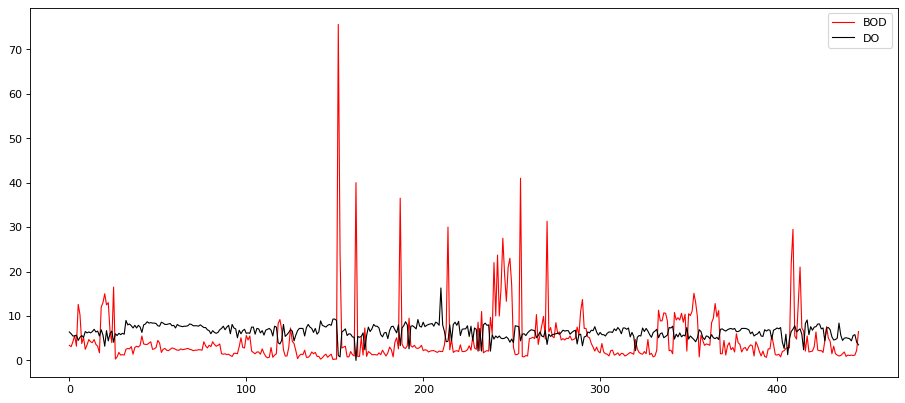

In [23]:
fig,ax3 = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax3.plot(range(0,size), bod, color='red', animated=True, linewidth=1, label='BOD')
ax3.plot(range(0,size), do, color='black', animated=True, linewidth=1, label='DO')
legend=ax3.legend()

In [24]:
con = spark.sql("Select CONDUCTIVITY from df_sql")
con = con.rdd.map(lambda row : row.CONDUCTIVITY).collect()
fec = spark.sql("Select FECAL_COLIFORM from df_sql")
fec = fec.rdd.map(lambda row : row.FECAL_COLIFORM).collect()

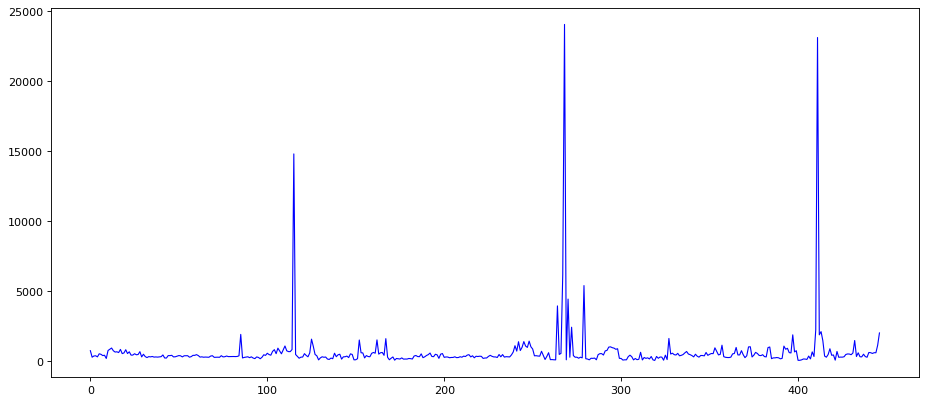

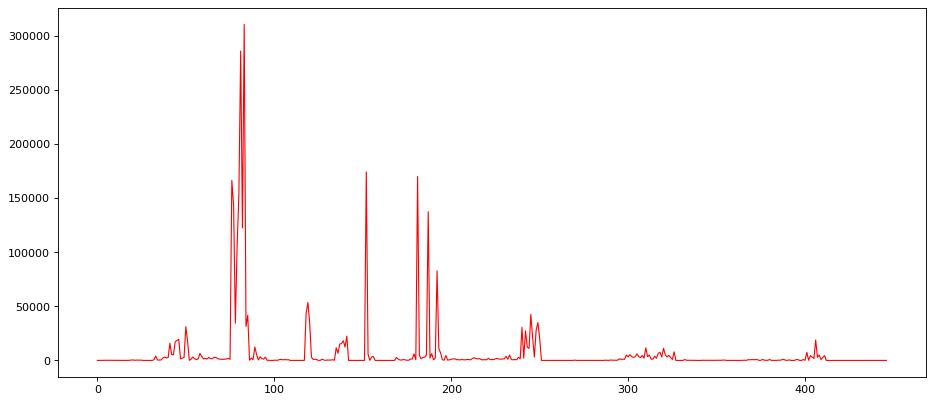

In [25]:
fig,ax = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,size), con, color='blue', animated=True, linewidth=1)
fig,ax2 = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax2.plot(range(0,size), fec, color='red', animated=True, linewidth=1)

# Feature engineering

In [26]:
df=df_clean.toPandas()
df.dtypes

STATION CODE            object
LOCATIONS               object
STATE                   object
TEMP                   float32
DO                     float32
pH                     float32
CONDUCTIVITY           float32
BOD                    float32
NITRATE_N_NITRITE_N    float32
FECAL_COLIFORM         float32
dtype: object

In [27]:
start=0
end=448
station=df.iloc [start:end ,0]
location=df.iloc [start:end ,1]
state=df.iloc [start:end ,2]
do= df.iloc [start:end ,4].astype(np.float64)
value=0
ph = df.iloc[ start:end,5]  
co = df.iloc [start:end ,6].astype(np.float64)
bod = df.iloc [start:end ,7].astype(np.float64)
na= df.iloc [start:end ,8].astype(np.float64)
fc=df.iloc [2:end ,9].astype(np.float64)

In [28]:
df=pd.concat([station,location,state,do,ph,co,bod,na,fc],axis=1)
df. columns = ['station','location','state','do','ph','co','bod','na','fc']

The Water Quality Index is calculated by aggregating the quality rating with the weight linearly:

WQI = ∑ (qn x Wn)

where qn =Quality rating for the nth Water quality parameter, Wn= unit weight for the nth parameters.

In [29]:
df['npH']=df.ph.apply(lambda x: (100 if (8.5>=x>=7)  
                                 else(80 if  (8.6>=x>=8.5) or (6.9>=x>=6.8) 
                                      else(60 if (8.8>=x>=8.6) or (6.8>=x>=6.7) 
                                          else(40 if (9>=x>=8.8) or (6.7>=x>=6.5)
                                              else 0)))))

In [30]:
df['ndo']=df.do.apply(lambda x:(100 if (x>=6)  
                                 else(80 if  (6>=x>=5.1) 
                                      else(60 if (5>=x>=4.1)
                                          else(40 if (4>=x>=3) 
                                              else 0)))))

In [31]:
df['nco']=df.fc.apply(lambda x:(100 if (5>=x>=0)  
                                 else(80 if  (50>=x>=5) 
                                      else(60 if (500>=x>=50)
                                          else(40 if (10000>=x>=500) 
                                              else 0)))))

In [32]:
df['nbdo']=df.bod.apply(lambda x:(100 if (3>=x>=0)  
                                 else(80 if  (6>=x>=3) 
                                      else(60 if (80>=x>=6)
                                          else(40 if (125>=x>=80) 
                                              else 0)))))

In [33]:
df['nec']=df.co.apply(lambda x:(100 if (75>=x>=0)  
                                 else(80 if  (150>=x>=75) 
                                      else(60 if (225>=x>=150)
                                          else(40 if (300>=x>=225) 
                                              else 0)))))

In [34]:
df['nna']=df.na.apply(lambda x:(100 if (20>=x>=0)  
                                 else(80 if  (50>=x>=20) 
                                      else(60 if (100>=x>=50)
                                          else(40 if (200>=x>=100) 
                                              else 0)))))

In [35]:
df.head()
df.dtypes

station      object
location     object
state        object
do          float64
ph          float32
co          float64
bod         float64
na          float64
fc          float64
npH           int64
ndo           int64
nco           int64
nbdo          int64
nec           int64
nna           int64
dtype: object


Now we apply the formula of wqi by first multiplying all the quality rating with its weight and then summed all the values.

In [36]:
df['wph']=df.npH * 0.165
df['wdo']=df.ndo * 0.281
df['wbdo']=df.nbdo * 0.234
df['wec']=df.nec* 0.009
df['wna']=df.nna * 0.028
df['wco']=df.nco * 0.281
df['wqi']=df.wph+df.wdo+df.wbdo+df.wec+df.wna+df.wco 
df

,station,location,state,do,ph,co,bod,na,fc,npH,...,nbdo,nec,nna,wph,wdo,wbdo,wec,wna,wco,wqi
0,1312,"GODAVARI AT JAYAKWADI DAM, AURNAGABAD,MAHARASHTRA",MAHARASHTRA,6.4,8.1,735.0,3.4,2.00,NaN,100,...,80,0,100,16.5,28.10,18.72,0.00,2.8,0.00,66.12
1,2177,GODAVARI RIVER NEAR SOMESHWAR TEMPLE.,MAHARASHTRA,6.0,8.0,270.0,3.1,2.00,NaN,100,...,80,40,100,16.5,28.10,18.72,0.36,2.8,0.00,66.48
2,2182,GODAVARI RIVER AT SAIKHEDA.,MAHARASHTRA,5.5,7.8,355.0,4.2,9.00,59.0,100,...,80,0,100,16.5,22.48,18.72,0.00,2.8,16.86,77.36
3,2179,"GODAVARI RIVER AT HANUMAN GHAT, NASHIK CITY.",MAHARASHTRA,5.5,7.8,371.0,5.6,3.55,90.0,100,...,80,0,100,16.5,22.48,18.72,0.00,2.8,16.86,77.36
4,2183,GODAVARI RIVER AT NANDUR- MADMESHWAR DAM.,MAHARASHTRA,5.7,7.9,294.0,3.2,2.69,45.0,100,...,80,40,100,16.5,22.48,18.72,0.36,2.8,22.48,83.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,2940,"GAPE- SAGAR LAKE, DUNGARPUR, RAJASTHAN",RAJASTHAN,4.4,8.1,538.0,1.2,1.00,5.0,100,...,100,0,100,16.5,16.86,23.40,0.00,2.8,28.10,87.66
443,2941,"LAKE JAISAMAND, SALUMBER, UDAIPUR, POINT NO. 1...",RAJASTHAN,5.6,8.4,591.0,1.1,3.00,4.0,100,...,100,0,100,16.5,22.48,23.40,0.00,2.8,28.10,93.28
444,2942,"LAKE JAISAMAND, SALUMBER, UDAIPUR, POINT NO. 2...",RAJASTHAN,5.8,8.5,588.0,1.2,3.00,4.0,100,...,100,0,100,16.5,22.48,23.40,0.00,2.8,28.10,93.28
445,2943,"LODHA TALAB, BANSWARA- DUNGARPUR ROAD, BANSWAR...",RAJASTHAN,4.1,7.9,1133.0,2.3,2.00,7.0,100,...,100,0,100,16.5,0.00,23.40,0.00,2.8,22.48,65.18



Now we classify the water on the basis of their water quality index

In [37]:
df['quality']=df.wqi.apply(lambda x:('Excellent' if (25>=x>=0)  
                                 else('Good' if  (50>=x>=26) 
                                      else('Poor' if (75>=x>=51)
                                          else('Very Poor' if (100>=x>=76) 
                                              else 'Unsuitable')))))

In [38]:
spark_df = sqlContext.createDataFrame(df)

In [39]:
spark_df.show()

+-------+--------------------+--------------+-----------------+-----------------+-----+------------------+------------------+-----+---+---+---+----+---+---+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+---------+
|station|            location|         state|               do|               ph|   co|               bod|                na|   fc|npH|ndo|nco|nbdo|nec|nna|               wph|               wdo|              wbdo|               wec|               wna|               wco|              wqi|  quality|
+-------+--------------------+--------------+-----------------+-----------------+-----+------------------+------------------+-----+---+---+---+----+---+---+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+---------+
|   1312|GODAVARI AT JAYAK...|   MAHARASHTRA|6.400000095367432|8.100000381469727|735.0|3.40000009536743

In [40]:
spark_df.createOrReplaceTempView("df_sql")

In [41]:
State = spark.sql("Select state from df_sql")
State = State.rdd.map(lambda row : row.state).collect()

In [42]:
Wqi = spark.sql("Select wqi from df_sql")
Wqi = Wqi.rdd.map(lambda row : row.wqi).collect()

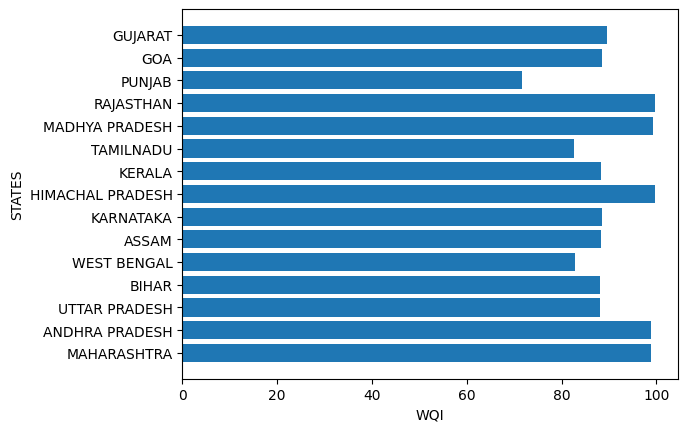

In [43]:
plt.barh(State,Wqi)

plt.xlabel("WQI")
plt.ylabel("STATES")


plt.show()

# Modeling

Now we apply machine learning algorithms to predict the data.

### Linear Regression Model

First we convert the required data to predict WQI into vector form by using VectorAssembler.

Then we normalize our data by using Normalizer.

In [44]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer

vectorAssembler = VectorAssembler(inputCols=["npH","ndo","nbdo","nec","nna","nco"], outputCol="features")
normalizer = Normalizer(inputCol="features",outputCol="features_norm")

Applying Linear Regresion model

In [45]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features_norm",labelCol="wqi",maxIter=10,regParam=0.3,elasticNetParam=0.2)

Now we streamline the processes into pipeline

In [46]:
from pyspark.ml import Pipeline

In [47]:
pipeline = Pipeline(stages=[vectorAssembler,normalizer,lr])

Now we split the data into train and test data

In [48]:
train_data,test_data=spark_df.randomSplit([0.8,0.2])

Fitting the data into the model

In [50]:
model = pipeline.fit(train_data)

Making predictions using the model

In [51]:
predictions = model.transform(train_data)

In [52]:
predictions.select("wqi","prediction").show()

+-----------------+-----------------+
|              wqi|       prediction|
+-----------------+-----------------+
|82.03999999999999|82.12383086684088|
|             82.4|81.92740963941318|
|            66.12|67.34565604943359|
|            66.12|67.34565604943359|
|             82.4|81.92740963941318|
|            77.72|77.78171638043395|
|77.36000000000001|77.89313076930208|
|            66.12|67.34565604943359|
|82.03999999999999|82.12383086684088|
|            66.12|67.34565604943359|
|            66.12|67.34565604943359|
|82.03999999999999|82.12383086684088|
|82.03999999999999|82.12383086684088|
|82.03999999999999|82.12383086684088|
|            66.12|67.34565604943359|
|            77.36|78.50416377454954|
|            82.98|83.11194223770477|
|             82.4|81.92740963941318|
|             77.9|77.91086130834056|
|            93.28|91.66703037750938|
+-----------------+-----------------+
only showing top 20 rows



Now we check the performance of our model

In [53]:
a=model.stages[2].summary.r2
a

0.9753564789532392

### Logistic Regression Model

Here we are creating a logistic regression model because we don't have to predict a continuous value.

In [54]:
from pyspark.ml.feature import StringIndexer

As our quality column contains values in string format so first we indexed them using StringIndexer

Then data is converted which are required to predict water quality into vector form by using VectorAssembler

Then we normalize our data by using Normalizer.

In [55]:
indexer = StringIndexer(inputCol="quality",outputCol="label")
vectorAssembler2 = VectorAssembler(inputCols=["npH","ndo","nbdo","nec","nna","nco","wqi"], outputCol="features2")
normalizer2 = Normalizer(inputCol="features2",outputCol="features_norm2")

Applying Logistic Regression Model

In [56]:
from pyspark.ml.classification import LogisticRegression
lor = LogisticRegression(featuresCol="features_norm2",labelCol="label",maxIter=10)

In [57]:
pipeline2 = Pipeline(stages=[indexer,vectorAssembler2,normalizer2,lor])

Now we split the data into train and test data

In [58]:
train_data,test_data=spark_df.randomSplit([0.8,0.2])

Fitting the data into the model

In [60]:
model2 = pipeline2.fit(train_data)

Making predictions using the model

In [61]:
predictions2 = model2.transform(train_data)

In [62]:
predictions2.select("label","prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



Now we check the performance of our model

In [64]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol('prediction')
b=eval.evaluate(predictions2)
b

0.9972144846796658


As the quality column is in string format so we convert our predicted data which are in numbers to their real string values and compare them with the actual data

In [65]:
names = ["Very Poor","Poor","Good","Unsuitable","Excellent"]

In [68]:
predictions2.createOrReplaceTempView("predictions2_sql")

In [67]:
pred = spark.sql("Select prediction from predictions2_sql")
pred = pred.rdd.map(lambda row : int(row.prediction)).collect()
qua = spark.sql("Select quality from predictions2_sql")
qua = qua.rdd.map(lambda row : row.quality).collect()

In [69]:
for x in range(100):
    print("Predicted:", names[pred[x]], "Actual:", qua[x])

Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Poor Actual: Poor
Predicted: Poor Actual: Poor
Predicted: Poor Actual: Poor
Predicted: Poor Actual: Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Poor Actual: Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Poor Actual: Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Good Actual: Good
Predicted: Very P

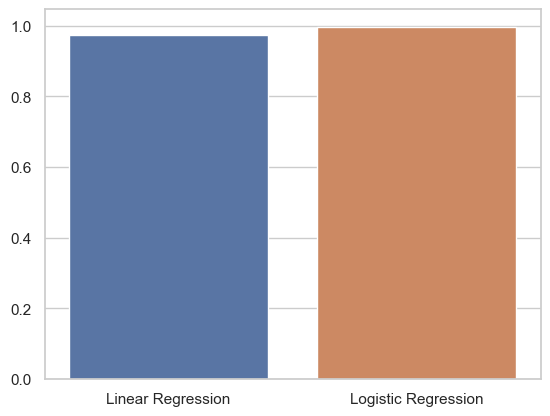

In [70]:
sns.set_theme(style='whitegrid')
scores = pd.DataFrame(data=[[a,b]],columns=['Linear Regression', 'Logistic Regression'])
sns.barplot(data=scores);